In [1]:
import cdsapi
import os
import ssl
import warnings
from pathlib import Path
from tqdm import tqdm

import warnings
import netCDF4
from netCDF4 import num2date
import zipfile
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from ipywidgets import interact, IntSlider
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
import rasterio as rio
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds


# Suppress all warnings
warnings.filterwarnings("ignore")


from sqlalchemy import create_engine, text
import pandas as pd

# Append the pyquacache path
sys.path.append(str(Path().resolve().parent))
import pyquacache.utils.queries as pqc
from pyquacache.defs.config import db_url_prod as db_url

# Download drainage basin boundaries
gdf = pqc.fetch_drainage_basin_boundaries()


data_dir = Path(".data")



In [19]:
gdf

,geom_id,geom_type,layer_name,description,geom,geometry
feature_name,,,,,,
08AA003,1,ST_Polygon,Drainage basins,DEZADEASH RIVER AT HAINES JUNCTION,0103000020AD10000001000000594B0000CCA2E96AA10E...,"POLYGON ((-136.4572 60.14162, -136.45856 60.14..."
08AA005,7,ST_Polygon,Drainage basins,AISHIHIK LAKE NEAR WHITEHORSE,0103000020AD100000010000006D26000047B0FF0F1422...,"POLYGON ((-137.06495 61.14286, -137.06588 61.1..."
08AA007,8,ST_Polygon,Drainage basins,SEKULMUN LAKE NEAR WHITEHORSE,0103000020AD1000000200000043180000FF414574FA2F...,"POLYGON ((-137.49932 61.48734, -137.49886 61.4..."
08AA008,9,ST_Polygon,Drainage basins,SEKULMUN RIVER AT OUTLET OF SEKULMUN LAKE,0103000020AD10000002000000FF170000FF414574FA2F...,"POLYGON ((-137.49932 61.48734, -137.49886 61.4..."
08AA009,10,ST_Polygon,Drainage basins,GILTANA CREEK NEAR THE MOUTH,0103000020AD10000001000000B30800008566D8E6CC18...,"POLYGON ((-136.77501 61.32439, -136.77641 61.3..."
...,...,...,...,...,...,...
29CA004,2109,ST_Polygon,Drainage basins,Quill Creek,0103000020AD10000001000000990500002BB1D13D0E72...,"POLYGON ((-139.56424 61.44901, -139.56438 61.4..."
29CA005,2110,ST_Polygon,Drainage basins,Christmas Creek,0103000020AD10000001000000F50500008D0999C69649...,"POLYGON ((-138.29966 60.92043, -138.29979 60.9..."
29CB007,2111,ST_Polygon,Drainage basins,Koidern River,0103000020AD10000001000000AD0F00001C87E0D1BE8F...,"POLYGON ((-140.49204 61.75094, -140.4921 61.75..."


In [4]:
import era5utils as era5
#era5.download_from_cds(
#    years=[2024, 2025]
#)
era5.zip_to_nc(source_dir=data_dir/"raw", destination_dir=data_dir/"extracted")


Unzipping files: 304it [00:06, 44.91it/s]


In [5]:
xda = era5.concatenate_to_xda(
    data_dir/"extracted",
    param="sd", 
    freq=None,
    resampling_function="mean"
    )
xda.values = xda.values * 1000 # Convert from m to mm
xda.attrs["units"] = "mm"


<xarray.DataArray 'sd' (time: 9226, latitude: 222, longitude: 301)> Size: 2GB
array([[[      nan,       nan,       nan, ..., 83.38261 , 87.23831 ,
         90.93475 ],
        [      nan,       nan,       nan, ..., 70.944786, 75.61779 ,
         83.30727 ],
        [      nan,       nan,       nan, ..., 64.128876, 67.27314 ,
         73.62747 ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 88.11569 , 92.30137 ,
         96.289635],
        [      nan,       nan,       nan, ..., 76.013565, 81.095695,
         89.07032 ],
        [      nan,       nan,       nan, ..., 69.81468 , 73.402405,
         80.1115  ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 2kB 50.0 50.1 50.2 50.3 ... 71.8 71.9 72.0
  * longitude  (longitude) float64 2kB -150.0 -149.9 -149.8 ... -120.1 -120.0
  * time       (time) datetime64[ns] 74kB 2000-01-01 2000-01-02 ... 2025-04-04
Attributes:
    count:                 {54: 41}
    name:                  {54: 'Snow depth'}
    units:                 mm
    Variable name in CDS:  {54: 'snow_depth'}
    shortName:             {54: 'sd'}
    ParamId:               {54: 141}
    an:                    {54: 'x'}
    fc:                    {54: 'x'}

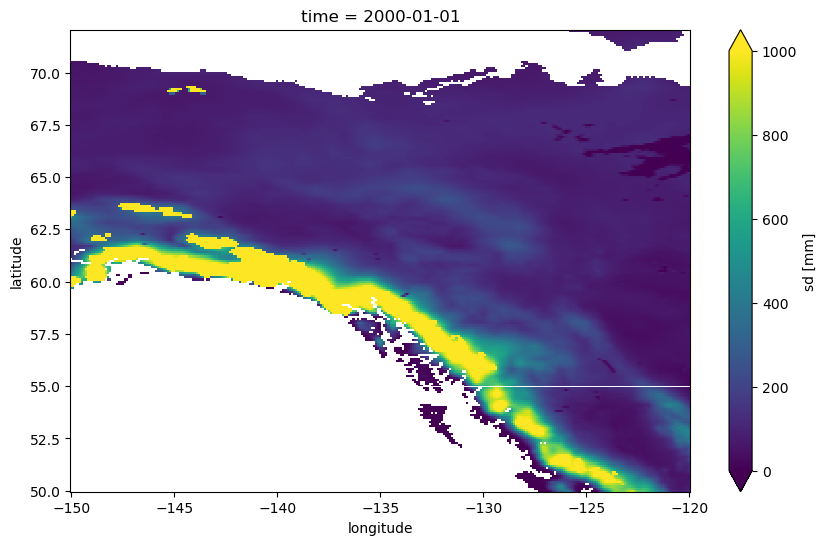

In [6]:
xda.sel(time=xda.time[0].values).plot(cmap="viridis", add_colorbar=True, figsize=(10, 6), vmin=0, vmax=1000)

In [7]:
xda
xda

<xarray.DataArray 'sd' (time: 9226, latitude: 222, longitude: 301)> Size: 2GB
array([[[      nan,       nan,       nan, ..., 83.38261 , 87.23831 ,
         90.93475 ],
        [      nan,       nan,       nan, ..., 70.944786, 75.61779 ,
         83.30727 ],
        [      nan,       nan,       nan, ..., 64.128876, 67.27314 ,
         73.62747 ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 88.11569 , 92.30137 ,
         96.289635],
        [      nan,       nan,       nan, ..., 76.013565, 81.095695,
         89.07032 ],
        [      nan,       nan,       nan, ..., 69.81468 , 73.402405,
         80.1115  ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 2kB 50.0 50.1 50.2 50.3 ... 71.8 71.9 72.0
  * longitude  (longitude) float64 2kB -150.0 -149.9 -149.8 ... -120.1 -120.0
  * time       (time) datetime64[ns] 74kB 2000-01-01 2000-01-02 ... 2025-04-04
Attributes:
    count:                 {54: 41}
    name:                  {54: 'Snow depth'}
    units:                 mm
    Variable name in CDS:  {54: 'snow_depth'}
    shortName:             {54: 'sd'}
    ParamId:               {54: 141}
    an:                    {54: 'x'}
    fc:                    {54: 'x'}

In [8]:

# resample to monthly
xda_monthly = xda.resample(time="1M").mean()

# by default, monthly means are taken at the end of the month, so we need to shift them to the start of the month
xda_monthly["time"] = pd.to_datetime(xda_monthly["time"].values) + pd.DateOffset(days=1)

historic_monthly_mean = xda_monthly.groupby("time.month").mean(dim="time", skipna=True)
historic_monthly_max = xda_monthly.groupby("time.month").max(dim="time", skipna=True)
historic_monthly_min = xda_monthly.groupby("time.month").min(dim="time", skipna=True)
historic_monthly_std = xda_monthly.groupby("time.month").std(dim="time", skipna=True)
historic_monthly_med = xda_monthly.groupby("time.month").median(dim="time", skipna=True)

xda_daily = xda.resample(time="1D").mean()
xda_daily["time"] = pd.to_datetime(xda_daily["time"].values, utc=True)
historic_yearly_mean =  xda_monthly.groupby("time.day").mean(dim="time", skipna=True)

#deviation_from_norm = deviation_from_norm.clip(min=-200, max=200)


In [9]:
xda_daily = xda.resample(time="1d").mean()
xda_daily["time"] = pd.to_datetime(xda_daily["time"].values)

start_hist = "2000-01-01"
end_hist = "2020-12-31"
historic_yearly_mean =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").mean(dim="time", skipna=True)
historic_yearly_med =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").median(dim="time", skipna=True)
historic_yearly_max =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").max(dim="time", skipna=True)
historic_yearly_min =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").min(dim="time", skipna=True)


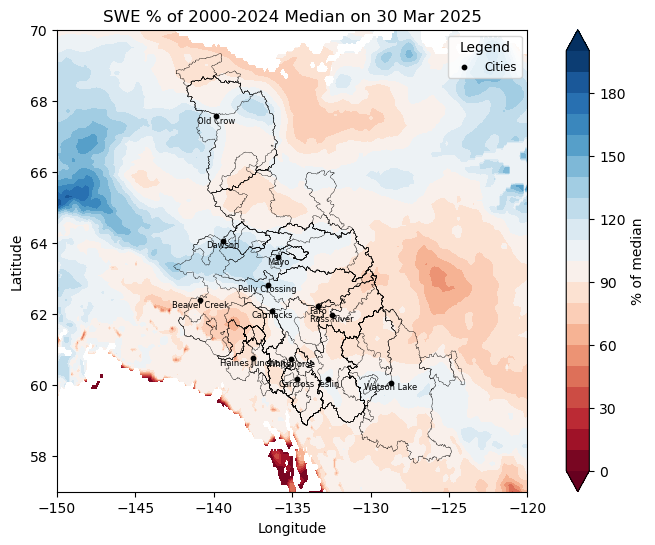

In [10]:


from datetime import datetime, timedelta
from pathlib import Path

# Example: Convert day of year 100 in the year 2025 to a datetime
year = 20
doy = 89
query_datetime = pd.Timestamp(datetime(2025, 1, 1) + timedelta(days=doy - 1))
historic_data = historic_yearly_mean.sel(dayofyear=doy)
data = xda_daily.sel(time=query_datetime, method="nearest")

deviation_from_norm = 100 * (data) / historic_data


fig, ax = plt.subplots(figsize=(10, 6))

# Create a contour plot for deviation_from_norm
contour = ax.contourf(
    deviation_from_norm.longitude,
    deviation_from_norm.latitude,
    deviation_from_norm.values,
    levels=np.linspace(0, 200, 21),  # Levels centered around 0
    cmap="RdBu",  # Red-White-Blue colormap
    extend='both'
)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, extend='both')
cbar.set_label(r"% of median")

# Add labels and title
ax.set_title(f"SWE % of 2000-2024 Median on {query_datetime.strftime('%d %b %Y')}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

gdf.plot(ax=ax, color="None", edgecolor="black", label='Locations', linewidth=0.2)

# Add cities to the map
cities = gpd.read_file(".data/shapes/cgn_yt_shp_eng.zip", crs="EPSG:4326")
cities = cities[(cities.CATEGORY == "Populated Place") & (cities.REL_SCALE.astype(int) > 3000000)]
for idx, row in cities.iterrows():
    ax.text(
        row.geometry.x, row.geometry.y, row.GEONAME,
        fontsize=6, color='black', ha='center', va='top'
    )
# Plot cities on the map
cities.plot(ax=ax, color='black', markersize=10, label='Cities')

# Update legend
ax.legend(loc='upper right', fontsize='small', title='Legend')

plt.ylim(57,70)
plt.show()


In [11]:
xda_notz = xda.copy()
xda_notz["time"] = pd.to_datetime(xda_notz["time"].values, utc=False)

def plot_xda_time(time_index):
    """
    Plot the xda data for a specific time index.
    """
    plt.figure(figsize=(10, 6))
    xda_notz.sel(time=xda_notz.time[time_index], method="nearest").plot(cmap="viridis", vmin=0, vmax=500)
    plt.title(f"Snow Depth on {str(xda_notz.time[time_index].values)}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Create an interactive slider
time_slider = IntSlider(min=0, max=len(xda_notz.time) - 1, step=1, value=0, description="Time Index")

# Use the interact function to link the slider to the plot function
interact(plot_xda_time, time_index=time_slider)

interactive(children=(IntSlider(value=0, description='Time Index', max=9225), Output()), _dom_classes=('widget…

<function __main__.plot_xda_time(time_index)>

In [12]:
# get SWE metadata
param_name = "snow water equivalent"
params = pqc.fetch_parameters(db_url)
param_md = params.loc[params["param_name"] == param_name, :]
param_md["unit_default"].values[0]

# get location IDs for SWE timeseries
engine = create_engine(db_url)
with engine.connect() as connection:
    out = connection.execute(
        text(f"SELECT * FROM continuous.timeseries WHERE parameter_id = {param_md.index[0]}")
    )

timeseries_df = pd.DataFrame(out).set_index("timeseries_id")
loc_ids = timeseries_df["location_id"]

# get locations at geodataframe
locations = pqc.fetch_locations(db_url).loc[loc_ids,:]

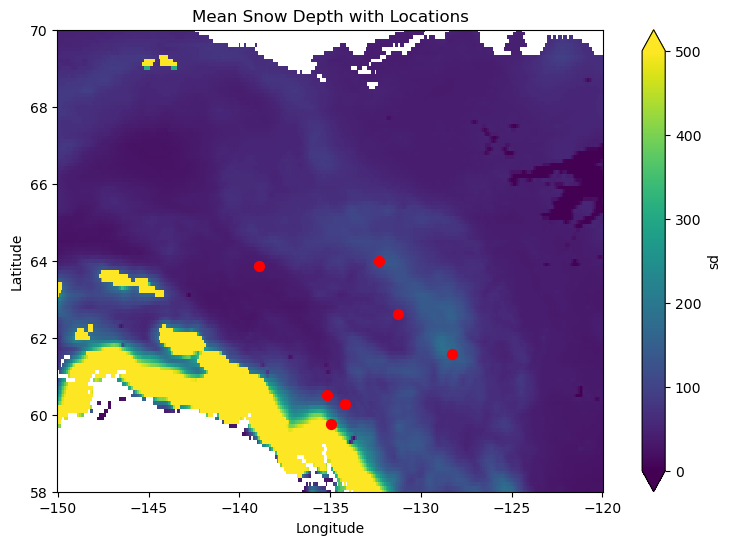

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot xda
xda.mean(dim="time").plot(ax=ax, cmap="viridis", add_colorbar=True, vmin=0, vmax=500)
locations.plot(ax=ax, color='red', label='Locations', markersize=50)

# Add title and labels
ax.set_title("Mean Snow Depth with Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_ylim(58, 70)
plt.show()

In [14]:
# download all contniuous SWE measurements
ts_ids = timeseries_df.index.tolist()
res = {}

def fetch_timeseries_corrected(ts_id, db_url=db_url):
    engine = create_engine(db_url)
    with engine.connect() as connection:
        out = connection.execute(
            text("SELECT * FROM continuous.measurements_continuous_corrected WHERE timeseries_id IN ({})".format(ts_id))
        )

        timeseries_md = connection.execute(
            text("SELECT * FROM continuous.timeseries WHERE timeseries_id IN ({})".format(ts_id))
        )
        timeseries_md = pd.DataFrame(timeseries_md).squeeze().to_dict()

        parameter_md = connection.execute(
            text("SELECT * FROM public.parameters WHERE parameter_id IN ({})".format(timeseries_md["parameter_id"]))
        )
        parameter_md = pd.DataFrame(parameter_md).squeeze().to_dict()

        out = pd.DataFrame(out).set_index("datetime")["value_corrected"]
        units = parameter_md["unit_default"]
        param = parameter_md["param_name"]
        tag = f"{ts_id}_{param}({units})"
        out.name = tag
        out = out.astype(float)
        out.to_frame()
        
        metadata = {"timeseries": timeseries_md, "parameter": parameter_md}
        return out, metadata

In [15]:
results = {}

for i, ts_id in enumerate(ts_ids):
    loc_id = timeseries_df.loc[ts_id, "location_id"]
    x, y = locations.loc[loc_id, "geometry"].x, locations.loc[loc_id, "geometry"].y

    era5_ts = xda.sel(longitude=x, latitude=y, method="nearest").to_dataframe().reset_index()
    era5_ts = era5_ts.set_index('time')['sd']

    yg_ts, _ = fetch_timeseries_corrected(ts_id)
    

    # aggregate to daily before syncing
    yg_ts = yg_ts.resample('D').mean().tz_localize(None)
    era5_ts = era5_ts.resample('D').mean()

    synced_ts = pd.concat([era5_ts, yg_ts], axis=1, join="outer")
    synced_ts.columns = ["ERA5", "YG"]

    results[ts_id] = synced_ts


In [16]:
results

{649:                   ERA5          YG
 2000-01-01  721.685425         NaN
 2000-01-02  721.721680         NaN
 2000-01-03  721.726440         NaN
 2000-01-04  721.945740         NaN
 2000-01-05  722.170837         NaN
 ...                ...         ...
 2025-04-12         NaN  302.458333
 2025-04-13         NaN  302.000000
 2025-04-14         NaN  302.000000
 2025-04-15         NaN  302.000000
 2025-04-16         NaN  301.958333
 
 [9238 rows x 2 columns],
 85:                   ERA5          YG
 2000-01-01  108.074188         NaN
 2000-01-02  108.075142         NaN
 2000-01-03  108.078003         NaN
 2000-01-04  108.080864         NaN
 2000-01-05  108.084679         NaN
 ...                ...         ...
 2025-04-12         NaN  213.000000
 2025-04-13         NaN  213.375000
 2025-04-14         NaN  212.875000
 2025-04-15         NaN  213.125000
 2025-04-16         NaN  213.142857
 
 [9238 rows x 2 columns],
 122:             ERA5          YG
 1992-10-15   NaN    0.000000
 1992-

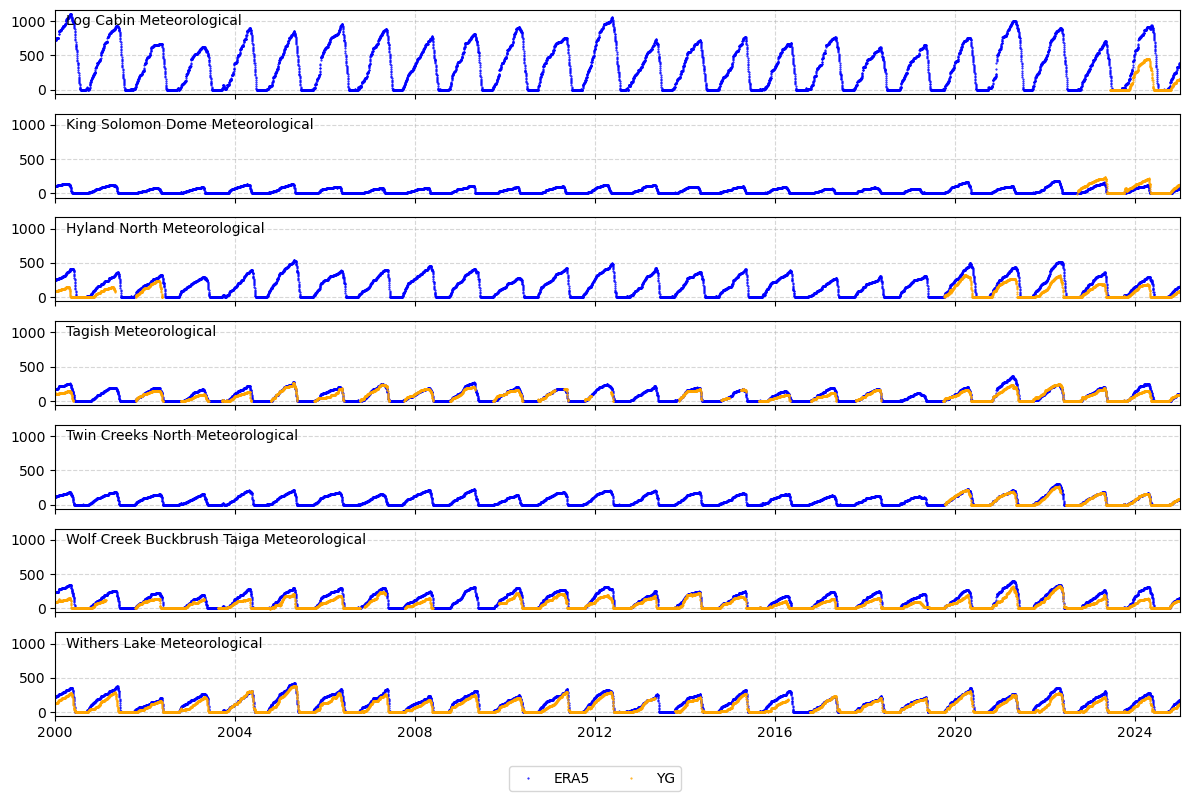

In [17]:
fig, axes = plt.subplots(7, 1, figsize=(12, 8), sharex=True, sharey=True)

axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, ts_id in enumerate(ts_ids):
    loc_id = timeseries_df.loc[ts_id, "location_id"]
    loc_name = locations.loc[loc_id, "name"]

    ax = axes[i]
    synced_ts = results[ts_id]
    ax.plot(synced_ts.index, synced_ts["ERA5"], label="ERA5", color="blue", marker='.', markersize=1, linestyle='', linewidth=0.5)
    ax.plot(synced_ts.index, synced_ts["YG"], label="YG", color="orange", marker='.', markersize=1, linestyle='', linewidth=0.5)

    # Add location annotation
    ax.text(0.01, 0.95, loc_name, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left')

    ax.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2025-01-01"))
    ax.grid(True, linestyle='--', alpha=0.5)

# Add a single legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for the legend
plt.show()

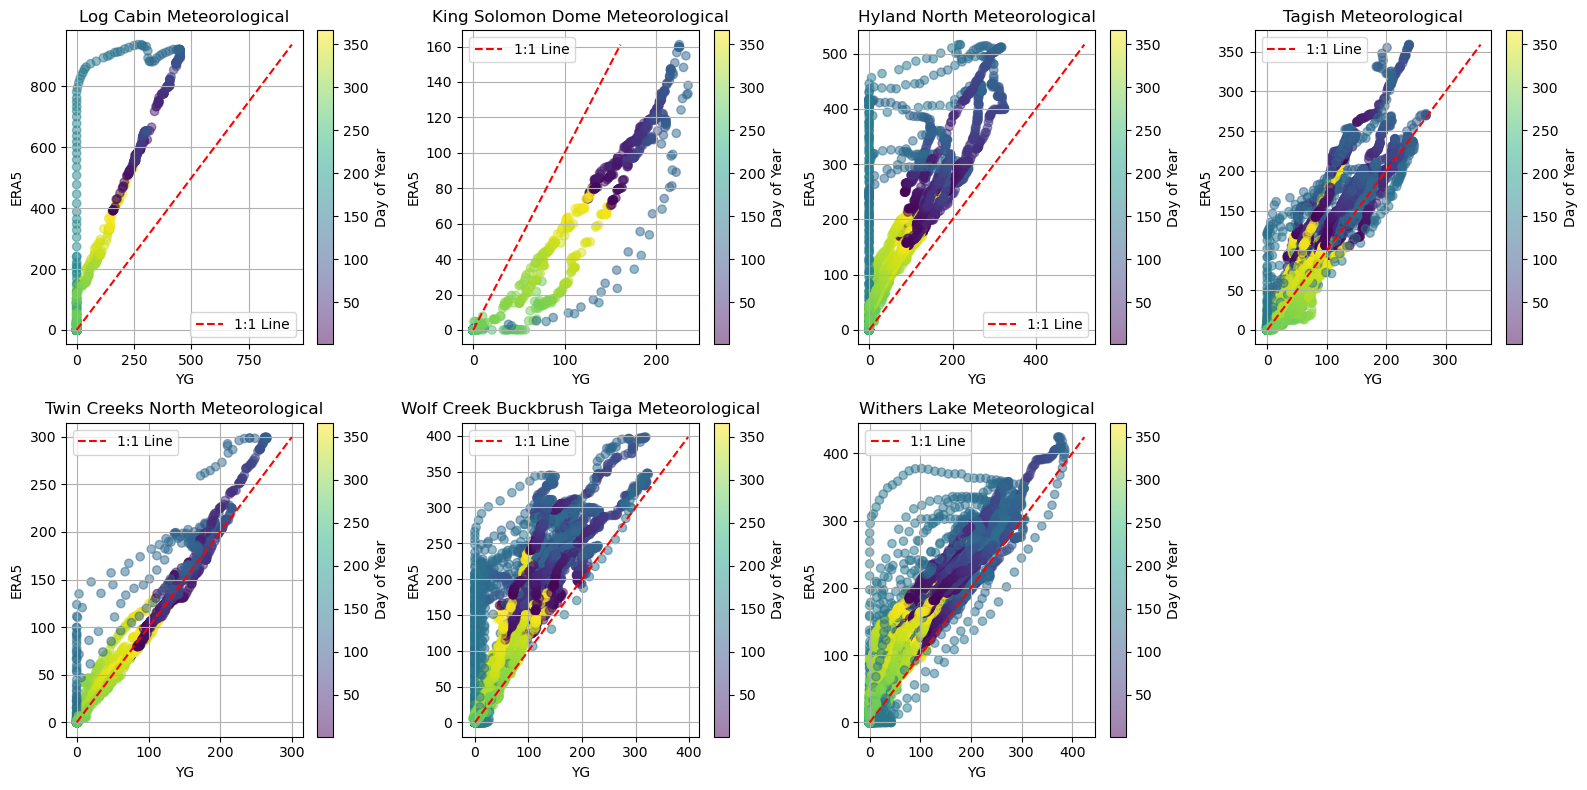

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Create a 2x4 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration

for ax, (ts_id, data) in zip(axes, results.items()):
    # Drop NaN values for clean comparison
    data = data.dropna()

    loc_id = timeseries_df.loc[ts_id, "location_id"]
    loc_name = locations.loc[loc_id, "name"]

    # Plot 1:1 scatter plot
    scatter = ax.scatter(data["YG"], data["ERA5"], c=data.index.dayofyear, cmap="viridis", alpha=0.5)
    plt.colorbar(scatter, ax=ax, label="Day of Year")
    
    ax.plot([data["ERA5"].min(), data["ERA5"].max()], [data["ERA5"].min(), data["ERA5"].max()], color="red", linestyle="--", label="1:1 Line")

    # Set labels and title
    ax.set_xlabel("YG")
    ax.set_ylabel("ERA5")
    ax.set_title(f"{loc_name}")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [19]:

import geopandas as gpd

locations_table = pqc.fetch_locations()

results_table = pqc.fetch_table(table_name="discrete.results").set_index("result_id")

results_table = results_table.loc[results_table["parameter_id"] == 21]

sample_ids = results_table.sample_id.unique()
samples_table = pqc.fetch_table(table_name="discrete.samples").set_index("sample_id")
results_table["location_id"] = samples_table.loc[results_table["sample_id"].values, "location_id"].values

results_table["datetime"] = samples_table.loc[results_table["sample_id"].values, "datetime"].values
results_table["target_datetime"] = samples_table.loc[results_table["sample_id"].values, "target_datetime"].values
results_table["datetime"] = results_table["datetime"].dt.tz_localize("UTC")

results_table["target_datetime"] = results_table["target_datetime"].dt.tz_localize("UTC")

results_table["geometry"] = locations_table.loc[results_table["location_id"].values, "geometry"].values
results_table = gpd.GeoDataFrame(results_table)

In [20]:
engine = create_engine(db_url)
with engine.connect() as connection:
    table_result = connection.execute(
        text(f"SELECT * FROM public.datum_conversions WHERE current = TRUE")
    )
datums_table = pd.DataFrame(table_result)

results_table["datum"] = datums_table.set_index("location_id").loc[results_table["location_id"].values, "conversion_m"].values
results_table["datum"] = results_table["datum"].astype(float)
results_table = results_table.apply(lambda col: pd.to_numeric(col, errors='ignore') if col.name not in ["datetime","target_datetime"] else col)

<Axes: >

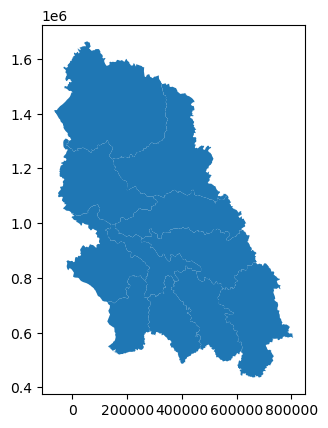

In [21]:
swe_basins = gpd.read_file(".data/shapes/swe_basins_ExportFeatures.zip", crs="EPSG:4326")
swe_basins.plot()

In [22]:
results_table["era5_result"] = np.nan

for name, row in tqdm(results_table.iloc[:,:].iterrows()):
    x, y = row.geometry.x, row.geometry.y
    dt = row.datetime

    # Even though ERA5 is UTC, the selection result is not localized in UTC
    res = xda.sel(longitude=x, latitude=y, time = dt, method="nearest")
    
    time_diff = dt - pd.Timestamp(res.time.values).tz_localize("UTC")
    time_diff = np.absolute(time_diff.days)

    if time_diff < 3:
        results_table.loc[name, "era5_result"] = res.values
    else:
        results_table.loc[name, "era5_result"] = np.nan


# Calculate the error (difference between observed and ERA5 results)
results_table["error"] = results_table["result"].astype(float) - results_table["era5_result"].astype(float)


0it [00:00, ?it/s]


TypeError: Cannot compare dtypes datetime64[ns] and datetime64[ns, UTC]

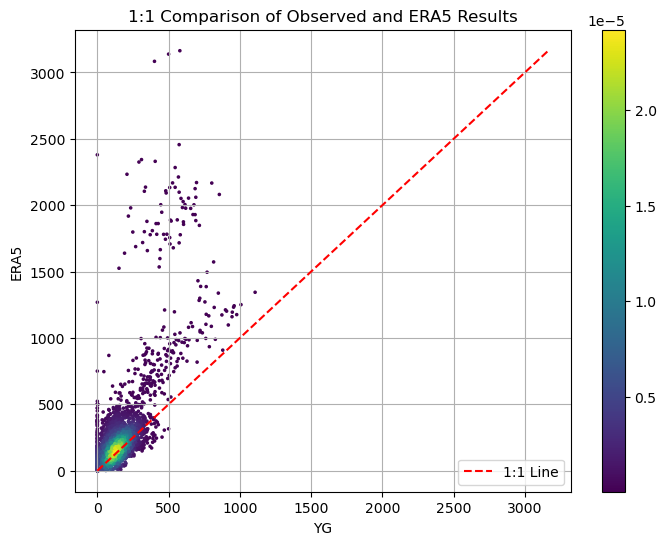

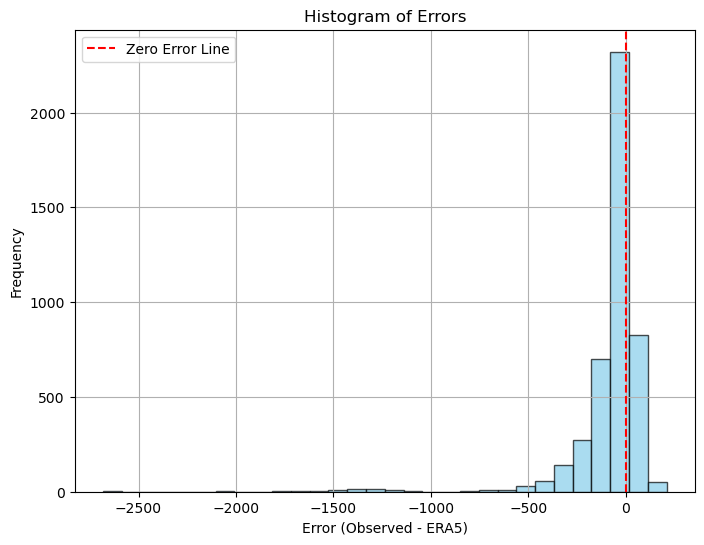

In [ ]:
from scipy.stats import gaussian_kde

# Drop rows with NaN values in either 'result' or 'era5_result'
results_table = results_table.dropna(subset=["result", "era5_result"])
results_table["result"] = results_table["result"].astype(float)
results_table["era5_result"] = results_table["era5_result"].astype(float)
# Extract day of year from the datetime column
results_table["day_of_year"] = results_table["datetime"].dt.dayofyear

# Create the 1:1 scatter plot
plt.figure(figsize=(8, 6))


# Scatter plot with colorized markers based on day of year
# Calculate the point density
xy = np.vstack([results_table["result"], results_table["era5_result"]])
z = gaussian_kde(xy)(xy)

# Scatter plot with colorized markers based on density
scatter = plt.scatter(
    results_table["result"],
    results_table["era5_result"],
    c=z,
    cmap="viridis",
    marker='.',
    s=10  # Marker size
)


# Add a colorbar
cbar = plt.colorbar(scatter)

# Add a 1:1 line
min_val = min(results_table["result"].min(), results_table["era5_result"].min())
max_val = max(results_table["result"].max(), results_table["era5_result"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="1:1 Line")

# Set plot labels and title
plt.xlabel("YG")
plt.ylabel("ERA5")
plt.title("1:1 Comparison of Observed and ERA5 Results")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Plot the histogram of errors
plt.figure(figsize=(8, 6))
plt.hist(results_table["error"], bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")

# Set plot labels and title
plt.xlabel("Error (Observed - ERA5)")
plt.ylabel("Frequency")
plt.title("Histogram of Errors")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

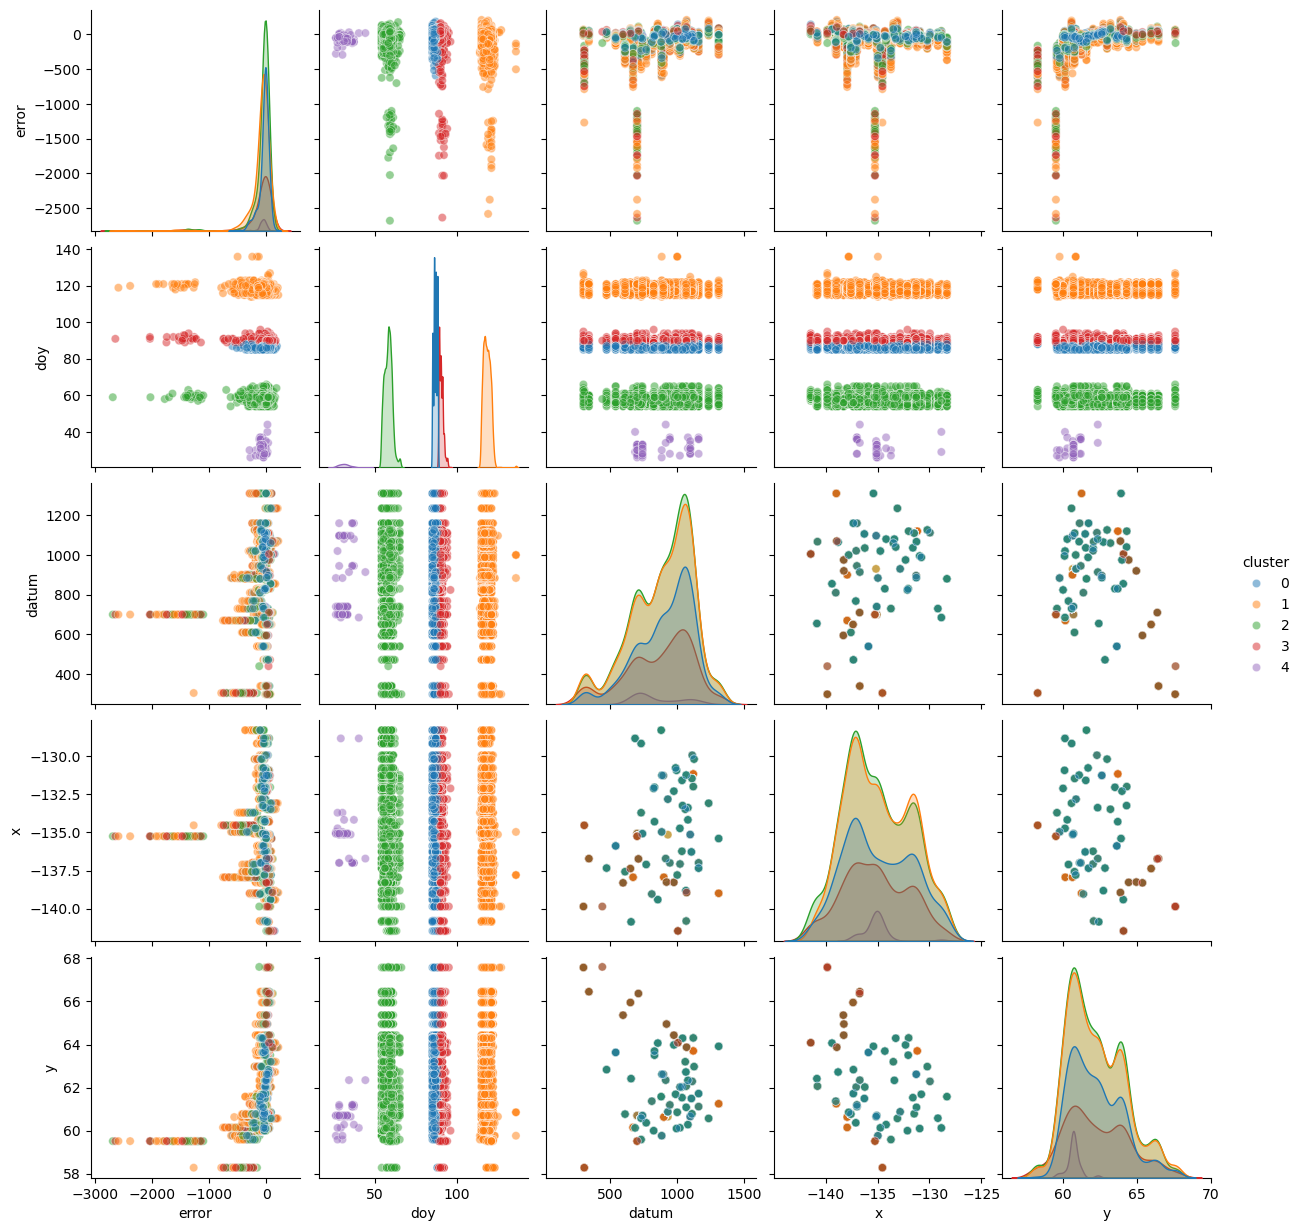

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans
results_table["x"] = results_table.geometry.x
results_table["y"] = results_table.geometry.y
results_table["doy"] = results_table.datetime.dt.dayofyear

# Select numeric columns for the scatterplot matrix
include_columns = ["error","doy","datum","x","y"]

# Perform KMeans clustering on the 'doy' column
kmeans = KMeans(n_clusters=5, random_state=42)
results_table['cluster'] = kmeans.fit_predict(results_table[['doy']])

# Create a scatterplot matrix with hue set to the cluster
sns.pairplot(results_table[include_columns + ['cluster']], diag_kind='kde', hue='cluster', plot_kws={'alpha': 0.5}, palette="tab10")

# Show the plot
plt.show()


In [ ]:
# load and preprocess the snowcourse factors
snowcourse_factors = pd.read_csv(r"C:\Users\esniede\Documents\github\YGwater\data-raw\snowcourse_factors.csv", index_col=1)
snowcourse_factors = snowcourse_factors[snowcourse_factors.index != "10AD-SC01"] # remove duplicate hyland river vaue
snowcourse_factors.drop(columns=["location_name"], inplace=True)
snowcourse_factors

,Liard,Pelly,Stewart,Peel,Porcupine,White,Central_Yukon,Lower_Yukon,Upper_Yukon,Teslin_Big_Salmon,Alsek
location_id,,,,,,,,,,,
10AA-SC03,1.4,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0
10AB-SC01,2.3,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10AA-SC01,0.7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10AD-SC01B,2.3,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09BA-SC05,0.3,0.70,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10AA-SC02,1.2,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0
10AA-SC04,0.3,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0
09BA-SC03,0.3,0.70,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0
09BC-SC01,0.0,1.95,0.00,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0


Timestamp('2004-03-01 19:00:00+0000', tz='UTC')

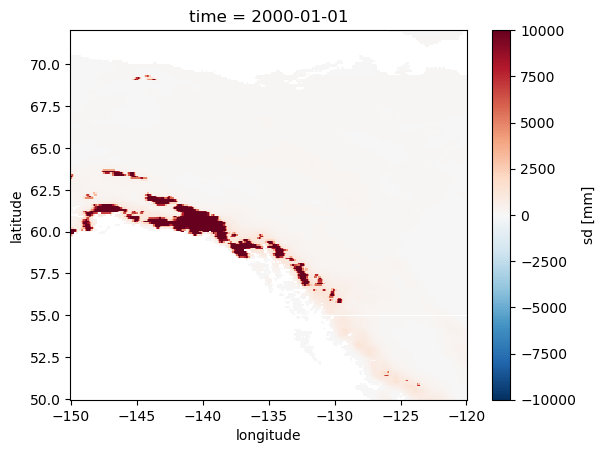

In [27]:

xda.sel(time=snow_survey_dates[10].tz_localize(None), method="nearest").plot()

In [24]:
# load and preprocess the snowcourse factors
from pyquacache.utils.spatialutils import poly_to_mask


snowcourse_factors = pd.read_csv(r"C:\Users\esniede\Documents\github\YGwater\data-raw\snowcourse_factors.csv", index_col=1)

snowcourse_factors = snowcourse_factors[snowcourse_factors.index != "10AD-SC01"] # remove duplicate hyland river vaue
snowcourse_factors.drop(columns=["location_name"], inplace=True)

locations = pqc.fetch_locations(db_url)

swe_basins = gpd.read_file(".data/shapes/swe_basins_ExportFeatures.zip").set_index("SWE_Basin")
swe_basins = swe_basins.to_crs("EPSG:4326")
# rename factors based on location ID
renaming_dict = {row["location"]:name for name, row in locations.iterrows()}
snowcourse_factors.index = snowcourse_factors.index.map(renaming_dict)


snow_survey_dates = results_table["target_datetime"].unique()


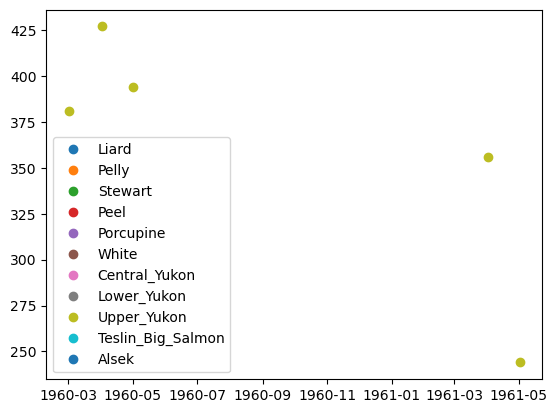

In [29]:

basin_avgs = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)

basin_avgs_era5 = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)

masks = poly_to_mask(reference_data=xda, poly=swe_basins)





for survey_date in snow_survey_dates[:5]:
    
    # copy the weights matrix; we're going to adjust the
    snowcourse_factors_corrected = snowcourse_factors.copy()
    idx = survey_date == results_table["target_datetime"]
    df = results_table.loc[idx,:]

    # get the locations of results available at the survey date
    location_codes = locations.loc[df["location_id"].values, "location"].values
    
    values = []

    # for each sampling location
    for loc, _ in snowcourse_factors_corrected.iterrows():
        idx = df["location_id"] == loc
        # if there are no results for the location, set the value to NaN
        if sum(idx) == 0:
            values.append(np.nan)

        # in the case where there are multiple results for the same location, take the mean of the results
        elif sum(idx) > 0:
            value = df.loc[idx, "result"].mean()
            values.append(value.mean())

    # add dim for matrix multiplication
    values = np.array(values).reshape(-1, 1)
    # set snowcourse factors to 0 if no value is available
    snowcourse_factors_corrected.loc[np.isnan(values).squeeze(),:] = 0
    # normalize for convex combination
    snowcourse_factors_corrected = snowcourse_factors_corrected.div(snowcourse_factors_corrected.sum(axis=0), axis=1)

    # Handle NaNs in values before matrix multiplication (these have a weight of 0, so the values don't matter, just can't be nan for matrix multiplication)
    values[np.isnan(values)] = 0

    # matrix multiplication and store the result in basin_avgs
    basin_avg = snowcourse_factors_corrected.T @ values
    basin_avgs.loc[survey_date, :] = basin_avg.squeeze()

    
    # remove UTC from survey date and convert to day
    snow_survey_day = snow_survey_dates.tz_localize(None).normalize()

    # get the basin average for the ERA5 data
    for loc in snowcourse_factors.columns:
        # get the mask for the location
        mask = masks[loc]
        # get the ERA5 data for the survey date
        era5_data = xda.sel(time=snow_survey_day, method="nearest").values
        # calculate the basin average using the mask
        basin_avgs_era5.loc[survey_date, loc] = np.nansum(era5_data * mask) / np.nansum(mask)
    
plt.plot(basin_avgs, label=basin_avgs.columns, marker='o', linestyle='')
plt.legend()

In [ ]:
xda.time[100]

<xarray.DataArray 'time' ()> Size: 8B
array('2000-04-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2000-04-10

<xarray.DataArray 'sd' (latitude: 222, longitude: 301)> Size: 267kB
array([[       nan,        nan,        nan, ..., 170.80212 , 188.05695 ,
        204.42772 ],
       [       nan,        nan,        nan, ..., 105.31807 , 124.7015  ,
        160.13718 ],
       [       nan,        nan,        nan, ...,  60.940742,  81.8758  ,
        115.57102 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 2kB 50.0 50.1 50.2 50.3 ... 71.8 71.9 72.0
  * longitude  (longitude) float64 2kB -150.0 -149.9 -149.8 ... -120.1 -120.0
    time       datetime64[ns] 8B 2000-04-10
Attributes:
    count:                 {54: 41}
    name:                  {54: 'Snow depth'}
    units:                 mm
    Variable name in CDS:  {54: 'snow_depth'}
    shortName:             {54: 'sd'}
    ParamId:               {54: 141}
    an:                    {54: 'x'}
    fc:                    {54: 'x'}

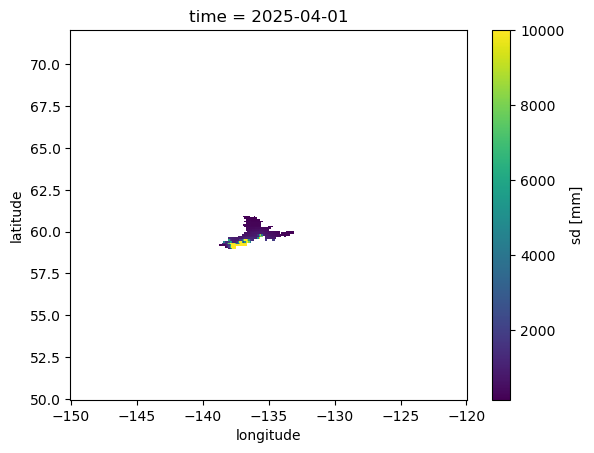

In [ ]:
The issue of a raster mask appearing flipped is often related to the coordinate system or the order of the latitude and longitude axes. Here are some common reasons and solutions:

### 1. **Coordinate Order**
    - Raster data often uses a coordinate system where the origin (0, 0) is at the top-left corner, and the latitude axis decreases as you move down the rows. However, some libraries (e.g., `xarray`) may assume the latitude axis increases from bottom to top.
    - **Solution**: Check the order of your latitude values in the `xda` object. If they are in descending order, you may need to reverse them before creating the mask.

    ```python
    if xda.latitude.values[0] > xda.latitude.values[-1]:
         xda = xda.sortby("latitude")
    ```

### 2. **Transform Mismatch**
    - The `rasterio.transform.from_bounds` function assumes the origin is at the top-left corner. If your data uses a different convention, the mask may appear flipped.
    - **Solution**: Ensure the transform matches the coordinate order of your data.

    ```python
    transform = from_bounds(
         xda.longitude.min().item(),
         xda.latitude.min().item(),
         xda.longitude.max().item(),
         xda.latitude.max().item(),
         len(xda.longitude),
         len(xda.latitude),
    )
    ```

### 3. **Geometry Mask**
    - The `geometry_mask` function in `rasterio` assumes the raster data follows the top-left origin convention. If your data uses a bottom-left origin, the mask will appear flipped.
    - **Solution**: Reverse the latitude axis or flip the mask after creation.

    ```python
    mask = geometry_mask(
         [geom],
         transform=transform,
         invert=True,
         out_shape=(len(xda.latitude), len(xda.longitude)),
    )
    mask = np.flipud(mask)  # Flip the mask vertically
    ```

### 4. **Plotting Issues**
    - Some plotting libraries (e.g., `matplotlib`) may flip the y-axis by default when displaying raster data.
    - **Solution**: Explicitly set the y-axis direction in your plot.

    ```python
    plt.imshow(mask, origin="upper")  # Ensure the origin is at the top
    ```

### 5. **CRS Misalignment**
    - If the coordinate reference system (CRS) of your `xda` object and the `poly` GeoDataFrame do not match, the mask may not align correctly.
    - **Solution**: Ensure both the `xda` and `poly` objects use the same CRS.

    ```python
    poly = poly.to_crs(xda.rio.crs)
    ```

By addressing these potential issues, you should be able to resolve the flipping problem with your raster mask.


<Axes: title={'center': 'time = 2025-04-01'}, xlabel='longitude', ylabel='latitude'>

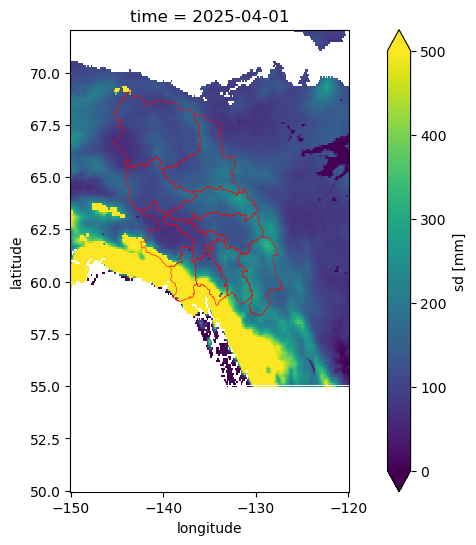

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot xda
era5_data.plot(ax=ax, cmap="viridis", add_colorbar=True, vmin=0, vmax=500)
swe_basins.plot(ax=ax, color="None", edgecolor="red", label='Locations', linewidth=0.4)


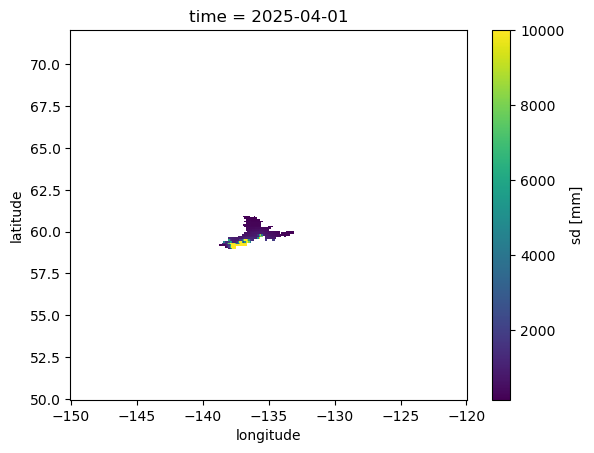

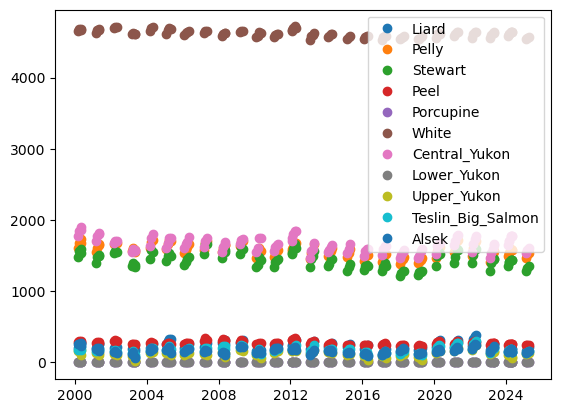

In [ ]:
plt.plot(basin_avgs_era5, label=basin_avgs_era5.columns, marker='o', linestyle='')
plt.legend()

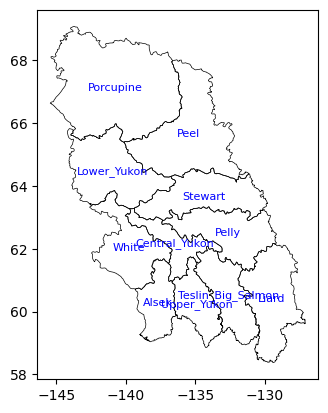

In [ ]:
swe_basins.plot(color="None", edgecolor="black", linewidth=0.5)
for basin_name, geom in zip(swe_basins.index, swe_basins.geometry):
    x, y = geom.centroid.x, geom.centroid.y
    plt.text(x, y, basin_name, fontsize=8, ha='center', va='center', color='blue')

In [ ]:
snow_survey_dates = results_table["target_datetime"].unique()

basin_avgs = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)

for survey_date in snow_survey_dates[:4]:
    
    # copy the weights matrix; we're going to adjust the
    snowcourse_factors_corrected = snowcourse_factors.copy()
    idx = survey_date == results_table["target_datetime"]
    df = results_table.loc[idx,:]

In [ ]:
df.loc[17949,:]

sample_id                                             8975
result_type                                              1
parameter_id                                            21
sample_fraction                                        NaN
result                                               597.0
result_condition                                       NaN
result_condition_value                                 NaN
result_value_type                                        1
result_speciation                                      NaN
protocol_method                                          1
laboratory                                             NaN
analysis_datetime                                      NaN
share_with                                 [public_reader]
no_update                                            False
created                                1727812606696754000
modified                              -9223372036854775808
location_id                                             

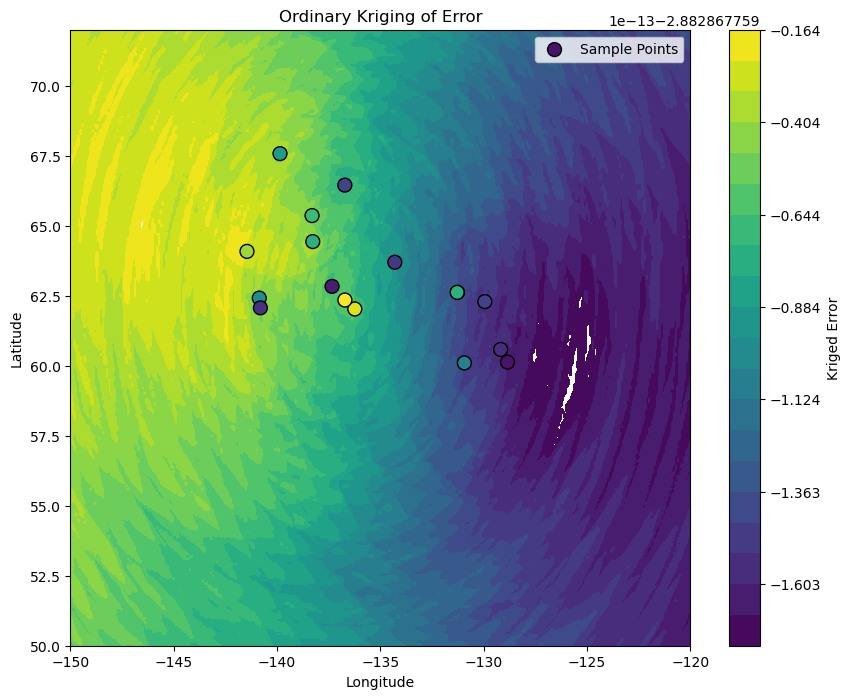

In [ ]:
from pykrige.ok import OrdinaryKriging

# Extract coordinates and the error values
filtered_df = df[np.abs(df["error"]) <= 20]
x_coords = filtered_df["x"].values
y_coords = filtered_df["y"].values
errors = filtered_df["error"].values

# Perform ordinary kriging
OK = OrdinaryKriging(
    x_coords, y_coords, errors,
    variogram_model="linear",  # You can also try 'spherical', 'exponential', etc.
    verbose=False,
    enable_plotting=False
)

# Define a grid for interpolation
grid_x = xda.longitude.values
grid_y = xda.latitude.values

grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Interpolate the error values on the grid
z, ss = OK.execute("grid", grid_x, grid_y)

# Plot the kriging result
plt.figure(figsize=(10, 8))
plt.contourf(grid_xx, grid_yy, z, cmap="viridis", levels=20)
plt.colorbar(label="Kriged Error")
plt.scatter(x_coords, y_coords, c=errors, cmap="viridis", edgecolor="k", label="Sample Points", s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ordinary Kriging of Error")
plt.legend()
plt.show()


In [ ]:
z

masked_array(
  data=[[-66.84108116513622, -66.84108116513622, -66.84108116513622, ...,
         -66.84108116513622, -66.84108116513622, -66.84108116513622],
        [-66.84108116513622, -66.84108116513622, -66.84108116513622, ...,
         -66.84108116513622, -66.84108116513622, -66.84108116513622],
        [-66.84108116513622, -66.84108116513622, -66.84108116513622, ...,
         -66.84108116513622, -66.84108116513622, -66.84108116513622],
        ...,
        [-66.8410811651362, -66.84108116513616, -66.84108116513616, ...,
         -66.84108116513622, -66.84108116513622, -66.84108116513622],
        [-66.8410811651362, -66.8410811651362, -66.84108116513616, ...,
         -66.84108116513622, -66.84108116513622, -66.84108116513622],
        [-66.8410811651362, -66.8410811651362, -66.8410811651362, ...,
         -66.84108116513622, -66.84108116513622, -66.84108116513383]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],


<xarray.DataArray 'time' (time: 9226)> Size: 74kB
array([946684800000000000, 946771200000000000, 946857600000000000, ...,
       1743552000000000000, 1743638400000000000, 1743724800000000000],
      dtype=object)
Coordinates:
  * time     (time) object 74kB 946684800000000000 ... 1743724800000000000

In [ ]:

masks = poly_to_mask(reference_data=xda, poly=swe_basins)

dti = pd.to_datetime(xda.time.values)


df = pd.DataFrame(index=dti, columns=swe_basins.index)


for dt in xda.time.values:
    for key, mask in masks.items():
        sampled_values = xda.sel(time=dt).where(mask)
        df.loc[dt, key] = sampled_values.mean().values
        
#df = df.astype(float)


KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

AttributeError: 'DataArray' object has no attribute 'datetime'

<Projected CRS: EPSG:3579>
Name: NAD83(CSRS) / Yukon Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - Yukon.
- bounds: (-141.01, 59.99, -123.91, 69.7)
Coordinate Operation:
- name: Yukon Albers
- method: Albers Equal Area
Datum: NAD83 Canadian Spatial Reference System
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

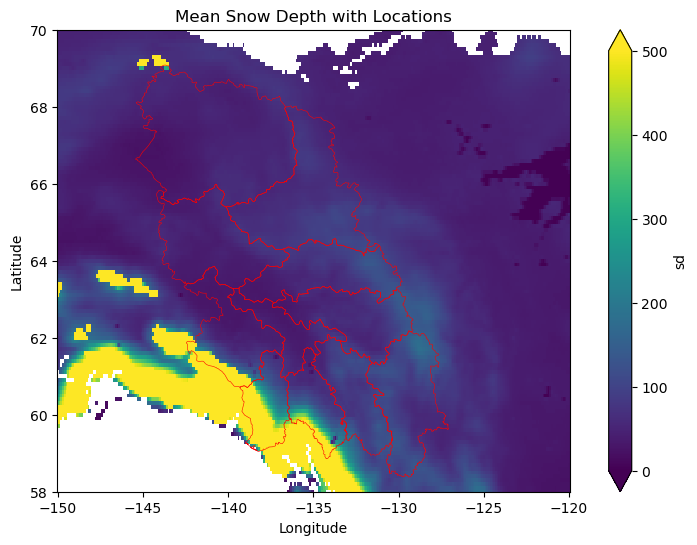

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot xda
xda.mean(dim="time").plot(ax=ax, cmap="viridis", add_colorbar=True, vmin=0, vmax=500)
swe_basins.plot(ax=ax, color="None", edgecolor="red", label='Locations', linewidth=0.4)

# Add title and labels
ax.set_title("Mean Snow Depth with Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_ylim(58, 70)
plt.show()


df = pd.DataFrame(index=xda.time.values, columns=gdf.index)
for dt in xda.time.values:
    for key, mask in masks.items():
        sampled_values = xda.sel(time=dt).where(mask)
        df.loc[dt, key] = sampled_values.mean().values
df = df.astype(float)

<Axes: >

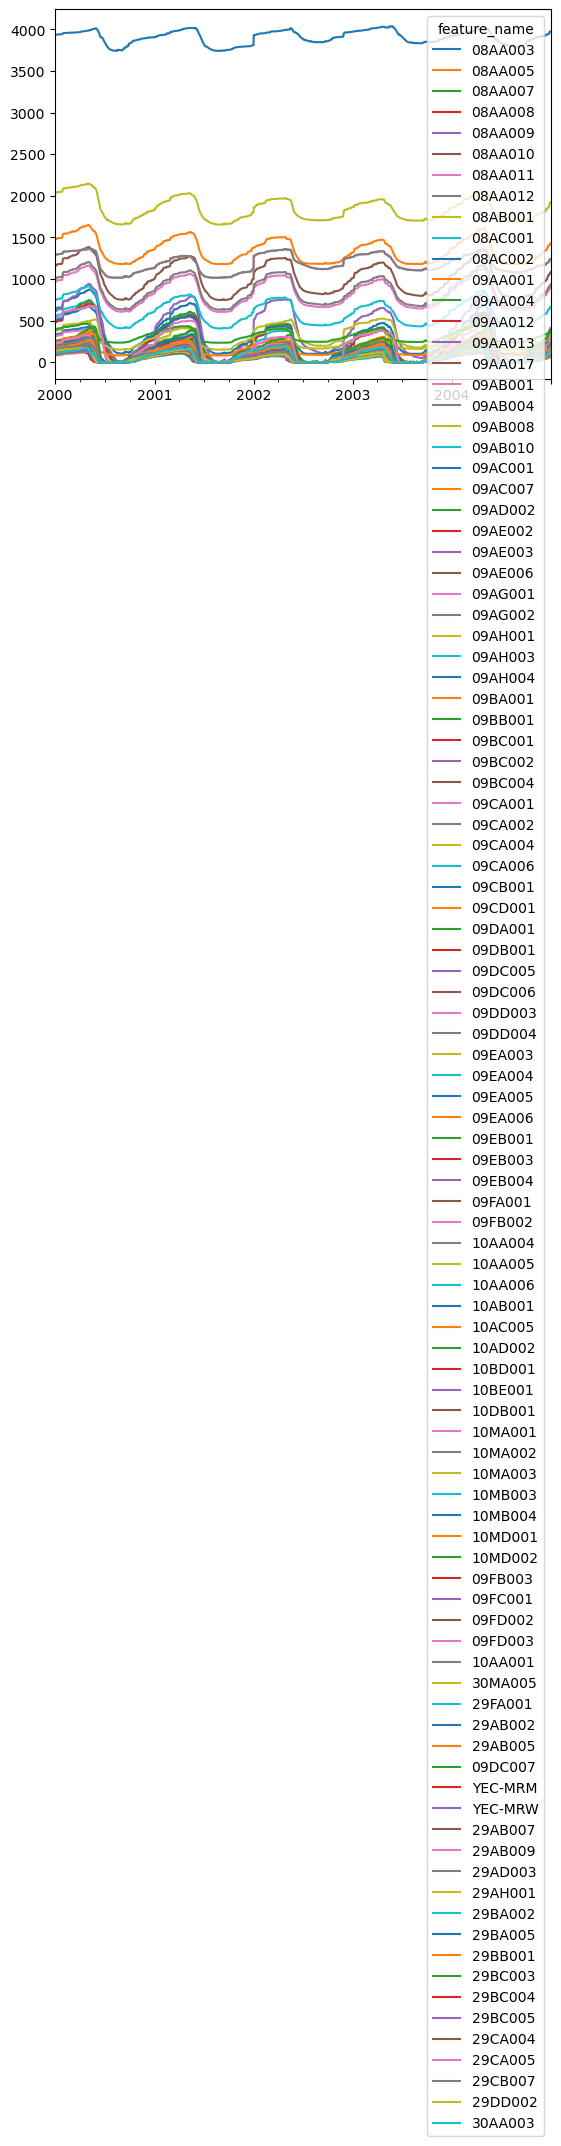

In [ ]:
df.plot()

<Axes: >

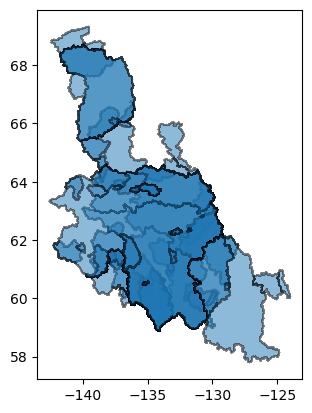

In [ ]:
gdf.plot(facecolor=None, edgecolor="black", alpha=0.5)

In [ ]:
len(masks)

100

AttributeError: 'dict' object has no attribute 'ites'

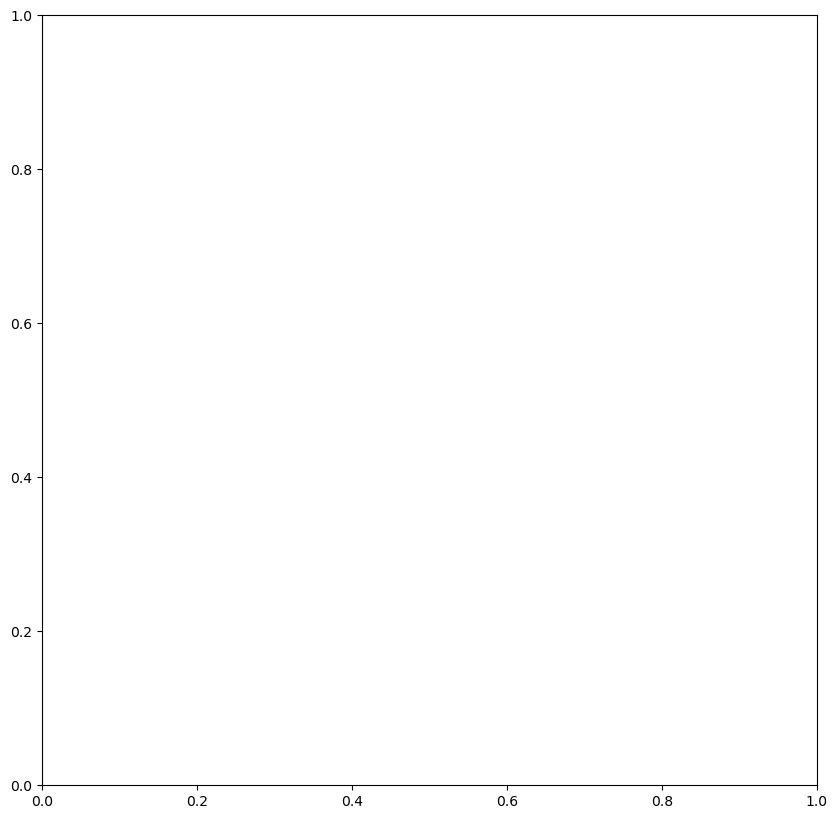

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))  # Create a single axis

# Iterate through masks and plot each one
for key, mask in masks.ites():
    ax.imshow(mask, cmap='Greens', alpha=0.5, interpolation='none', label=key)

# Add a legend
ax.legend(loc='upper right', fontsize='small', title='Masks')

# Set title and turn off axes
ax.set_title("Combined Masks")

plt.tight_layout()
plt.show()

In [ ]:
masks

{'08AA003': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '08AA005': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '08AA007': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [Fal